In [780]:
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import seaborn as sns

# Imports & EDA

In [781]:
# inspect the downloaded datasets (reminder: kb is bytes/1024. mb is bytes/(1024*1024))

project_files_dir = os.path.dirname(
    os.path.abspath(__name__)
)

for item in os.listdir(project_files_dir):
    if item.endswith('.csv'):
        file_path = os.path.join(project_files_dir, item)
        file_size = os.path.getsize(file_path) / (1024**2)
        file_name = item.strip('.csv')

        print("_"*100)
        print(f"Dataset '{file_name}' is {round(file_size,2)} mb in size:\n")
        
        if 'dictionary' in str(item):
            print(pd.read_csv(file_path))
        
        else:                
            print(pd.read_csv(file_path, nrows=100).info())  # don't import entire raw file, in case its huge


____________________________________________________________________________________________________
Dataset 'Listing' is 151.15 mb in size:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   listing_id                   100 non-null    int64  
 1   name                         100 non-null    object 
 2   host_id                      100 non-null    int64  
 3   host_since                   100 non-null    object 
 4   host_location                100 non-null    object 
 5   host_response_time           0 non-null      float64
 6   host_response_rate           0 non-null      float64
 7   host_acceptance_rate         0 non-null      float64
 8   host_is_superhost            100 non-null    object 
 9   host_total_listings_count    100 non-null    int64  
 10  host_has_profile_pic         100 non-null    object 


In [782]:
# import the listings df (reviews dfs are not necessary for this project)

needed_columns = ['host_since', 'neighbourhood', 'city', 'accommodates', 'price']
listing_path = os.path.join(project_files_dir, 'Listings.csv')

listings_df = pd.read_csv(
    listing_path,
    encoding='latin1',
    usecols=needed_columns,
    parse_dates=['host_since']
)

listings_df.info() 
listings_df.describe()

# observations;
# relatively light file, can inspect first and then decide how much to scale down the dtypes
# need to get rid of the listings where price == 0 as its useless 
# host_since has some nulls, but they have some potentially valuable price info. might get rid of 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279712 entries, 0 to 279711
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   host_since     279547 non-null  datetime64[ns]
 1   neighbourhood  279712 non-null  object        
 2   city           279712 non-null  object        
 3   accommodates   279712 non-null  int64         
 4   price          279712 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 10.7+ MB


,accommodates,price
count,279712.000000,279712.000000
mean,3.288736,608.792737
std,2.133379,3441.826611
min,0.000000,0.000000
25%,2.000000,75.000000
50%,2.000000,150.000000
75%,4.000000,474.000000
max,16.000000,625216.000000


In [784]:
# clean df & filter for paris listings only

paris_listings =\
    listings_df.loc[
        (listings_df['city'].str.lower().str.contains('paris'))
    ]\
    .reset_index()\
    .drop_duplicates()\
    .drop(columns=['index'])\
    .dropna(subset='host_since')\
    .query("price > 0.00") 

# observation:
# price and host_since make up a miniscule % of total records, but removing anyway for preciseness 

# Apply Proper DataTypes:

In [785]:
# before...
print(paris_listings.info())
print("_"*100)
# print(paris_listings.value_counts())
print("_"*100)
print(paris_listings.describe())
print("_"*100)
paris_listings['neighbourhood'].nunique()

# observations:
# price has a max of 12k, can bring down the bytesize to 16. leave as float since price can have cents
# accomodates has a max of 16, can bring down to 8 bytes. can do int since people only come in whole numbers
# 20 unique neighborhoods in a dataset of 60k+ rows, good candidate for category dtype

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64595 entries, 0 to 64689
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   host_since     64595 non-null  datetime64[ns]
 1   neighbourhood  64595 non-null  object        
 2   city           64595 non-null  object        
 3   accommodates   64595 non-null  int64         
 4   price          64595 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.0+ MB
None
____________________________________________________________________________________________________
____________________________________________________________________________________________________
       accommodates         price
count  64595.000000  64595.000000
mean       3.040483    113.213174
std        1.586691    214.553894
min        1.000000      8.000000
25%        2.000000     59.000000
50%        2.000000     80.000000
75%        4.000000  

20

In [786]:
# apply changes:
paris_listings['host_since'] = pd.to_datetime(paris_listings['host_since'])  # convert to datetime
paris_listings['neighbourhood'] = paris_listings['neighbourhood'].astype('category')
paris_listings['city'] = paris_listings['city'].astype('category')
paris_listings['price'] = paris_listings['price'].round(2).astype('float32')  # describe shows max of 36k, can bring down to 32bit
paris_listings['accommodates'] = paris_listings['accommodates'].astype('int8')  # max is 16, and people can't be floats

# after...
print(paris_listings.info())
print("_"*100)
# print(paris_listings.value_counts())
print("_"*100)
print(paris_listings.describe())

# observations:
# shaved down >50% off the original size 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64595 entries, 0 to 64689
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   host_since     64595 non-null  datetime64[ns]
 1   neighbourhood  64595 non-null  category      
 2   city           64595 non-null  category      
 3   accommodates   64595 non-null  int8          
 4   price          64595 non-null  float32       
dtypes: category(2), datetime64[ns](1), float32(1), int8(1)
memory usage: 1.4 MB
None
____________________________________________________________________________________________________
____________________________________________________________________________________________________
       accommodates         price
count  64595.000000  64595.000000
mean       3.040483    113.213173
std        1.586691    214.546265
min        1.000000      8.000000
25%        2.000000     59.000000
50%        2.000000     80.000000
75%      

# Creating df's for visualization:

In [789]:
# create chart for avg price per neighborhood 

paris_listings_neighbourhood = paris_listings\
    .groupby('neighbourhood')\
    .agg({'price':'mean'})\
    .sort_values('price', ascending=0)\
    .reset_index()

In [791]:
# get most expensive neighborhood name & avg price
most_expensive_neighborhood = paris_listings_neighbourhood.query('price == price.max()').values[0][0]
most_expensive_neighborhood_value = paris_listings_neighbourhood.query('price == price.max()').values[0][1]

# filter original df for only most expensive neighborhood
paris_listings_accomodations = paris_listings.loc[paris_listings['neighbourhood'] == most_expensive_neighborhood]

# get average price by n accomodations for most expensive neighborhood
paris_listings_accomodations = \
    paris_listings_accomodations\
        .groupby('accommodates')\
        .agg(n_reservations=('price', 'count'), price=('price','mean'))\
        .reset_index()\
        .assign(neighbourhood=str(most_expensive_neighborhood))\
        .sort_values('price', ascending=0)

In [792]:
# find average price and n_hosts over time
paris_listings_over_time = \
    paris_listings.assign(year=paris_listings['host_since'].dt.year) \
    .groupby('year')\
    .agg({'price':'mean', 'city':'count'})\
    .reset_index()\
    .rename(columns={'city':'n new hosts', 'price': 'avg yearly price'})

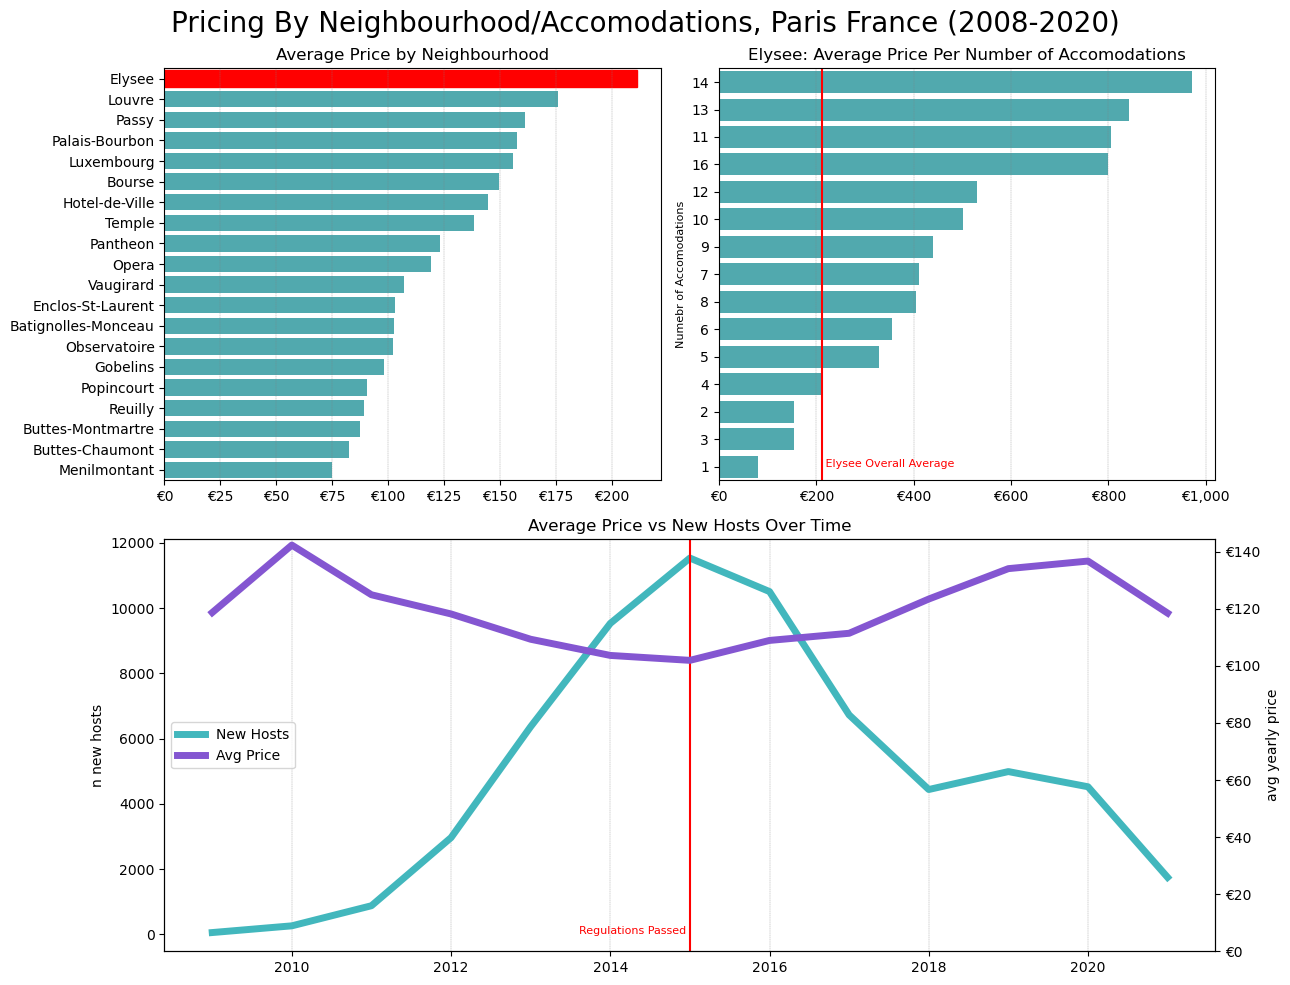

In [805]:
# categorical datatypes will get alphabetically ordered when graphing: best to convert to str prior to charting
paris_listings_neighbourhood['neighbourhood'] = paris_listings_neighbourhood['neighbourhood'].astype('str')
paris_listings_accomodations['accommodates'] = paris_listings_accomodations['accommodates'].astype('str')

fig, ax = plt.subplots(2, 2, figsize=[13,10])
gs = gridspec.GridSpec(2,2, height_ratios=[1,1])

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,:])
ax4 = ax3.twinx()

# 1. bar (avg price per hood)
sns.barplot(
    data=paris_listings_neighbourhood,
    y='neighbourhood',
    x='price',
    ax=ax1,
    color='#42b7bd'
)

# 2. bar (most expensive hood broken down by n accomdiations)
sns.barplot(
    data=paris_listings_accomodations,
    y='accommodates',
    x='price',
    ax=ax2,
    color='#42b7bd'
)

# 3. line (dual axis) number of new hosts yearly
sns.lineplot(
    data=paris_listings_over_time,
    x='year',
    y=paris_listings_over_time['n new hosts'].rolling(2).mean(),
    ax=ax3,
    color='#42b7bd',
    linewidth=5,
    label='New Hosts',
    legend=False

)

# 4. line (dual axis) avg price yearly
sns.lineplot(
    data=paris_listings_over_time,
    x='year',
    y=paris_listings_over_time['avg yearly price'].rolling(2).mean(),
    color='#8456D1',
    linewidth=5,
    ax=ax4,
    label='Avg Price',
    legend=False
)

# title and label formatting 
plt.suptitle('Pricing By Neighbourhood/Accomodations, Paris France (2008-2020)', fontsize=20, ha='center')

ax1.set_title('Average Price by Neighbourhood', fontsize=12)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2.set_title(f'{most_expensive_neighborhood}: Average Price Per Number of Accomodations', fontsize=12)
ax2.set_xlabel('')
ax2.set_ylabel('Numebr of Accomodations', fontsize=8)

ax3.set_title('Average Price vs New Hosts Over Time', fontsize=12)
ax3.set_xlabel('')

# # add avg price line for most expensive neighborhood 
ax2.axvline(x=most_expensive_neighborhood_value, color='red')
ax2.text(
    x=most_expensive_neighborhood_value, 
    y=14, 
    s=f" {most_expensive_neighborhood} Overall Average ",
    color='red',
    fontsize=8,
    ha='left'
)

# add line on 2015 when new laws passed 
ax3.axvline(x=2015, color='red')
ax3.text(2015, 0, 'Regulations Passed ', color='red', fontsize=8, ha='right')

# # format pricing cols as currency
ax1.xaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}'))
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}'))
ax4.yaxis.set_major_formatter(ticker.StrMethodFormatter('€{x:,.0f}'))

# misc

lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='center left')

ax4.set_ylim(0)

# highlight the most expensive neighbourhood in first chart
for bar in ax1.patches:
    if bar.get_width() >= most_expensive_neighborhood_value:
        bar.set_color('red')
        
# add gridlines to all
for ax in [ax1, ax2, ax3]:
    ax.grid(axis='x', linestyle='--', linewidth=0.25, color='gray')

plt.tight_layout()
plt.show()
